# Detecting Pneumonia with xray images

### Pneumonia definition
Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.
More detailed info about pneumonia: [click](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=Pneumonia%20is%20an%20infection%20that,and%20fungi%2C%20can%20cause%20pneumonia.)

How does the lungs look when it has Pneumonia?
![alt text](https://assets.aboutkidshealth.ca/akhassets/Pneumonia_XRAY_MEDIMG_PHO_EN.png?RenditionID=19)



##  Uploading the Dataset from kaggle 

In [ ]:
# #upload the credentials of the kaggle account
# from google.colab import files
# files.upload()

In [ ]:
#  #before importing the dataset we want to use this code
#  # The Kaggle API client expects this file to be in ~/.kaggle,
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# #This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# #import the dataset we want to use for our project
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# !pip install zip_files

In [ ]:
# from zipfile import ZipFile
# file_name = "/content/chest-xray-pneumonia.zip"
# with ZipFile (file_name, "r") as zip:
#   zip.extractall()
#   print("done")

**Dataset Content**


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Importing the dependencies 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


## Uploading the Dataset

In [ ]:
train = get_training_data("/content/chest_xray/train")
val = get_training_data("/content/chest_xray/val")
test = get_training_data("/content/chest_xray/test")

## Data Visualization

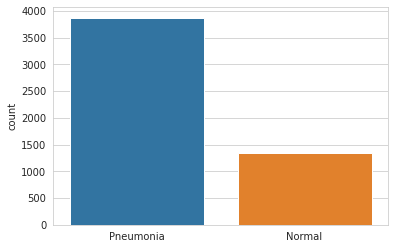

In [ ]:
l = []
for s in train:
  if (s[1]==0):
    l.append("Pneumonia")
  else:
    l.append("Normal")  
sns.set_style('whitegrid')
sns.countplot(l);     

- From the countplot, it is noticeable that We are dealing with imbalanced dataset for the training.  We have almost with thrice pneumonia cases here as compared to the normal cases. This situation is very normal when it comes to medical data. The data will always be imbalanced. either there will be too many normal cases or there will be too many cases with the disease.

 **Previewing the images**

Text(0.5, 1.0, 'NORMAL')

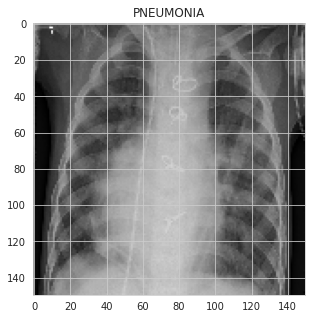

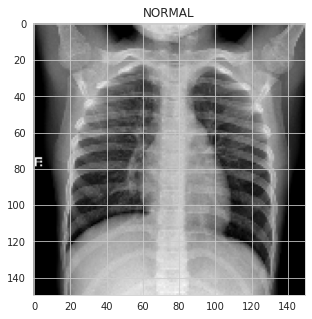

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, the followings were chosen :

* Randomly rotate some training images by 30 degrees
* Randomly Zoom by 20% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset.

## Training the model 

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 19, 19, 128)      

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
163/163 [==============================] - 16s 95ms/step - loss: 0.5216 - accuracy: 0.7467 - val_loss: 0.7058 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 9s 56ms/step - loss: 0.4210 - accuracy: 0.8014 - val_loss: 0.4847 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 9s 57ms/step - loss: 0.3126 - accuracy: 0.8738 - val_loss: 0.4466 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 9s 56ms/step - loss: 0.2636 - accuracy: 0.8928 - val_loss: 0.3451 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 9s 56ms/step - loss: 0.2272 - accuracy: 0.9084 - val_loss: 1.0697 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 9s 55ms/step - loss: 0.1904 - accuracy: 0.9225 - val_loss: 1.0001 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 9s 56ms/step - loss: 0.1660 - accuracy: 0.9323 - val_loss: 0.9158 - val_accuracy: 0.750

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 273us/step
Loss of the model is -  44.00896738784817 %
624/624 [==============================] - 0s 251us/step
Accuracy of the model is -  88.30128312110901 %


# Analyssy after modeling 

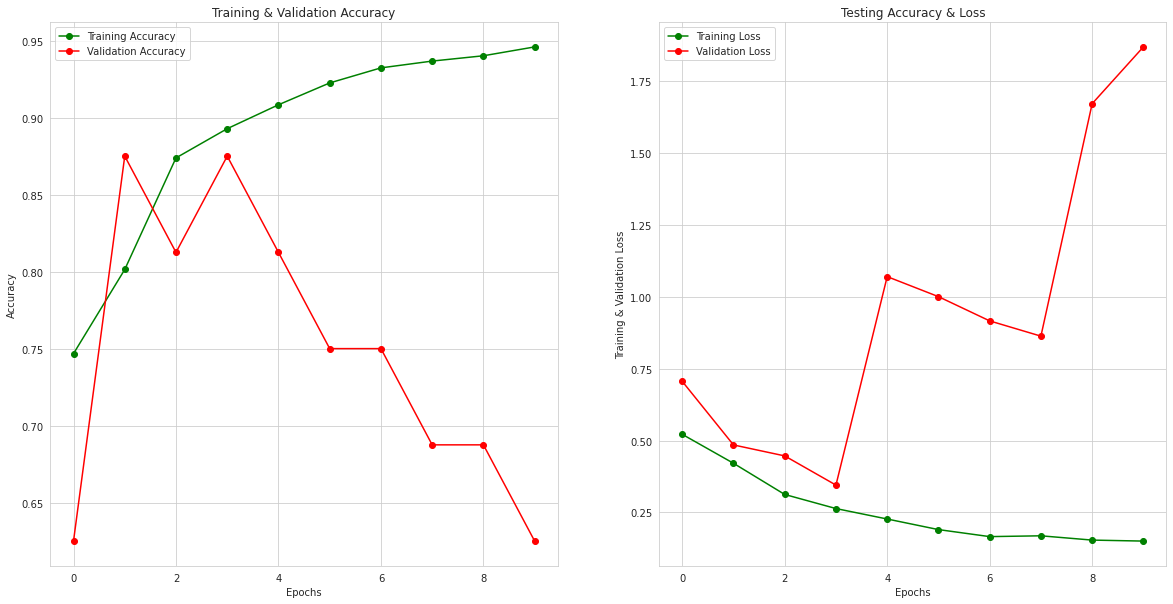

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()


In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.97      0.91       390
   Normal (Class 1)       0.94      0.74      0.83       234

           accuracy                           0.88       624
          macro avg       0.90      0.85      0.87       624
       weighted avg       0.89      0.88      0.88       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[378,  12],
       [ 61, 173]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

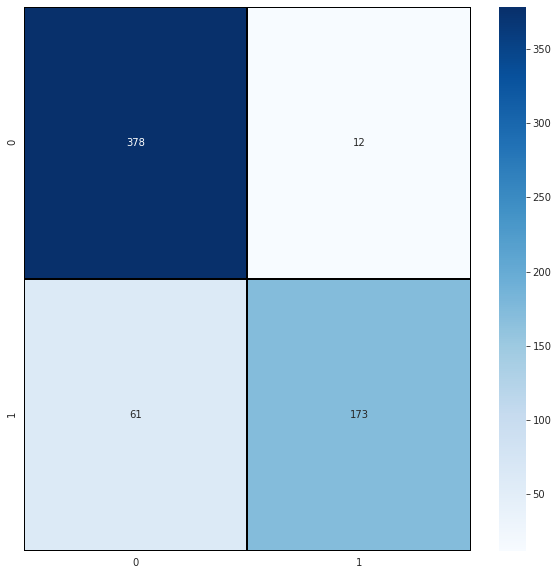

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**some correctly predicted classes**

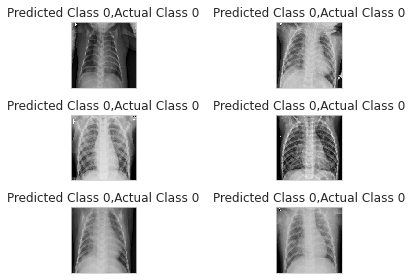

In [ ]:
#Some of the Correctly Predicted Classes

i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1